In [8]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib



In [5]:
# Load the dataset
df = pd.read_csv('animosic_dataset.csv')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Handle missing Artist Genres
df['Artist Genres'] = df['Artist Genres'].fillna("Unknown")

# Remove duplicates based on Track URI
df = df.drop_duplicates(subset=['Track URI'], keep='first')

# Standardize Mood labels
df['Mood'] = df['Mood'].str.strip().str.title()

# Save the cleaned dataset
df.to_csv('animosic_dataset_cleaned.csv', index=False)

# Print summary
print("\nMood distribution:\n", df['Mood'].value_counts())
print(f"\nTotal songs: {len(df)}")
print("\nSample of cleaned dataset:\n", df.head())

Missing values:
 Track URI          0
Track Name         0
Artist Name(s)     0
Artist Genres     16
Danceability       0
Energy             0
Speechiness        0
Valence            0
Tempo              0
Mood               0
dtype: int64

Mood distribution:
 Mood
Joyful         200
Melancholic    150
Party          150
Focus/Study    100
Calm           100
Reflective     100
Romantic       100
Workout        100
Name: count, dtype: int64

Total songs: 1000

Sample of cleaned dataset:
                               Track URI  \
0  spotify:track:6ybViy2qrO9sIi41EgRJgx   
1  spotify:track:5RWcE4Poc4Un93zzhwKvrK   
2  spotify:track:6Sueudn0VQA4AXRsFKQbFl   
3  spotify:track:3zByVQLvdXUaDTubfWkpCk   
4  spotify:track:7ddUIAiI2kH0rLBbi27wrH   

                              Track Name          Artist Name(s)  \
0                         Don't Know Why             Norah Jones   
1                       Unchained Melody  The Righteous Brothers   
2                          Amazing Grace     

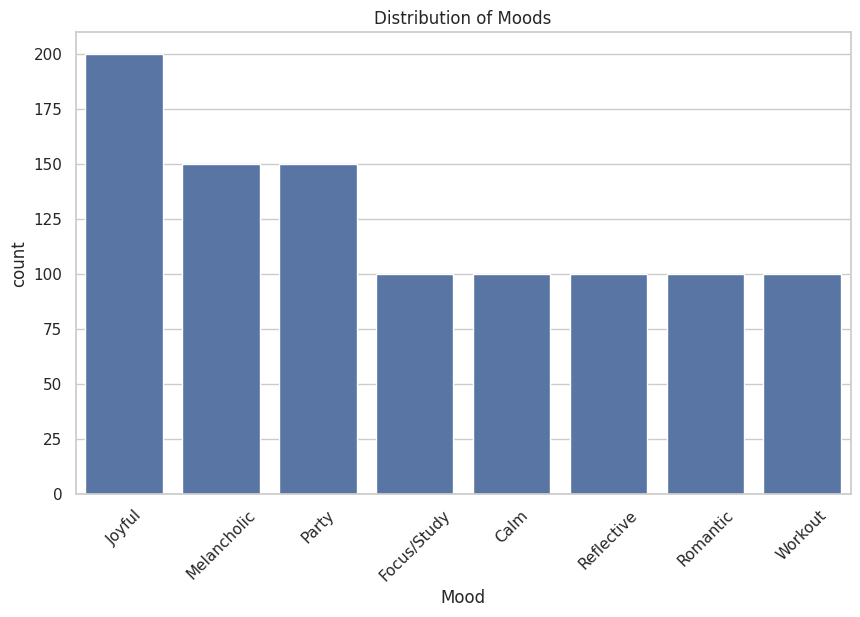

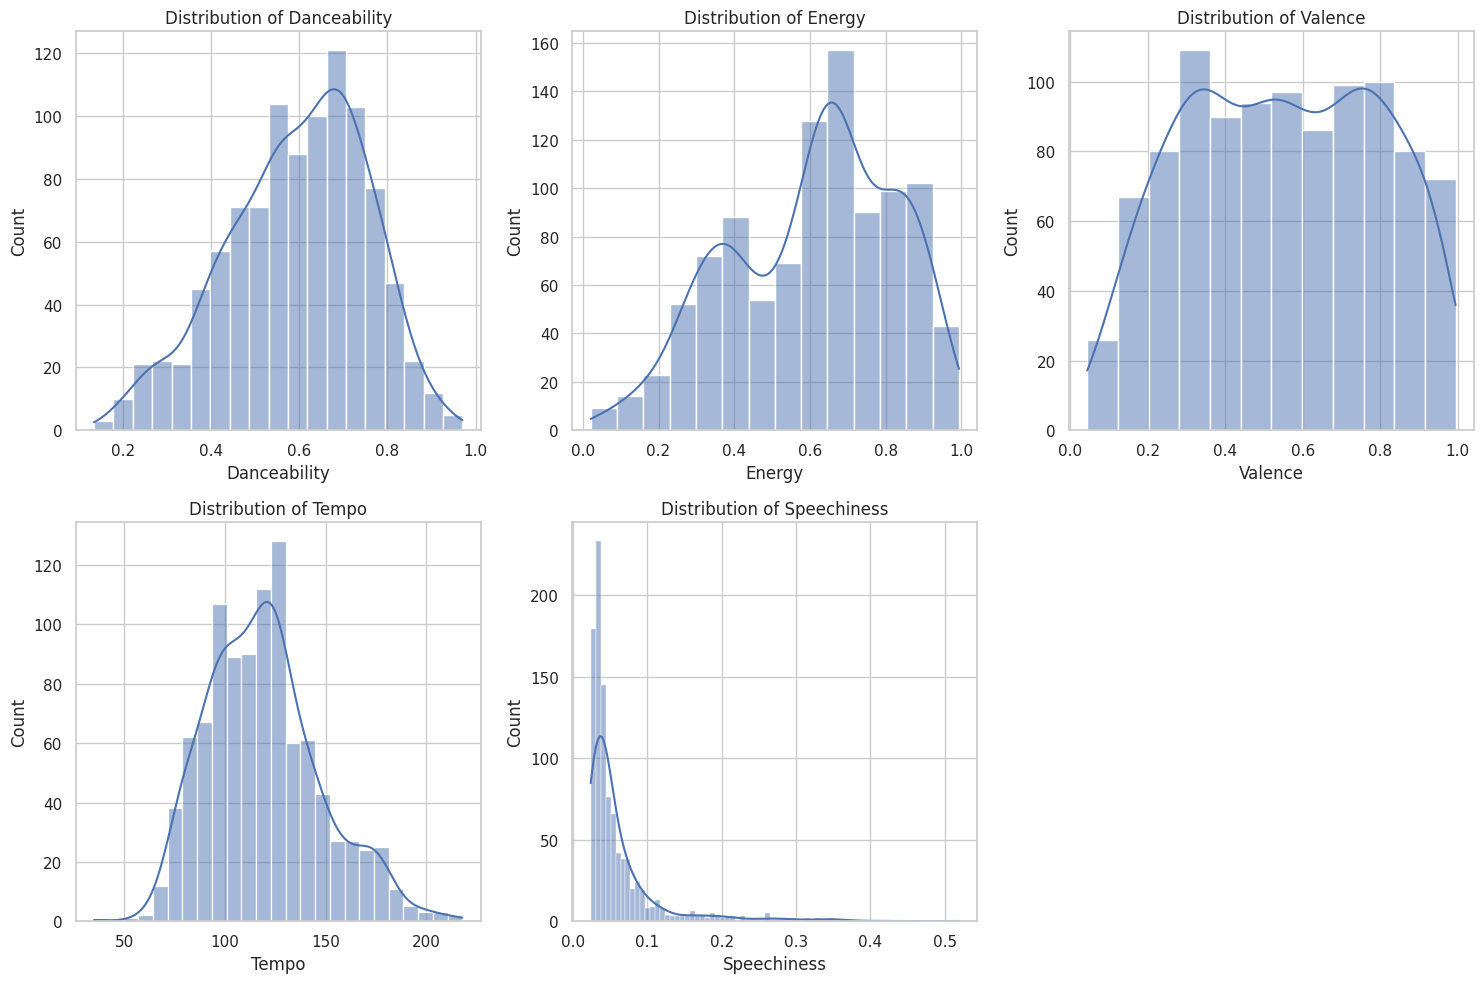

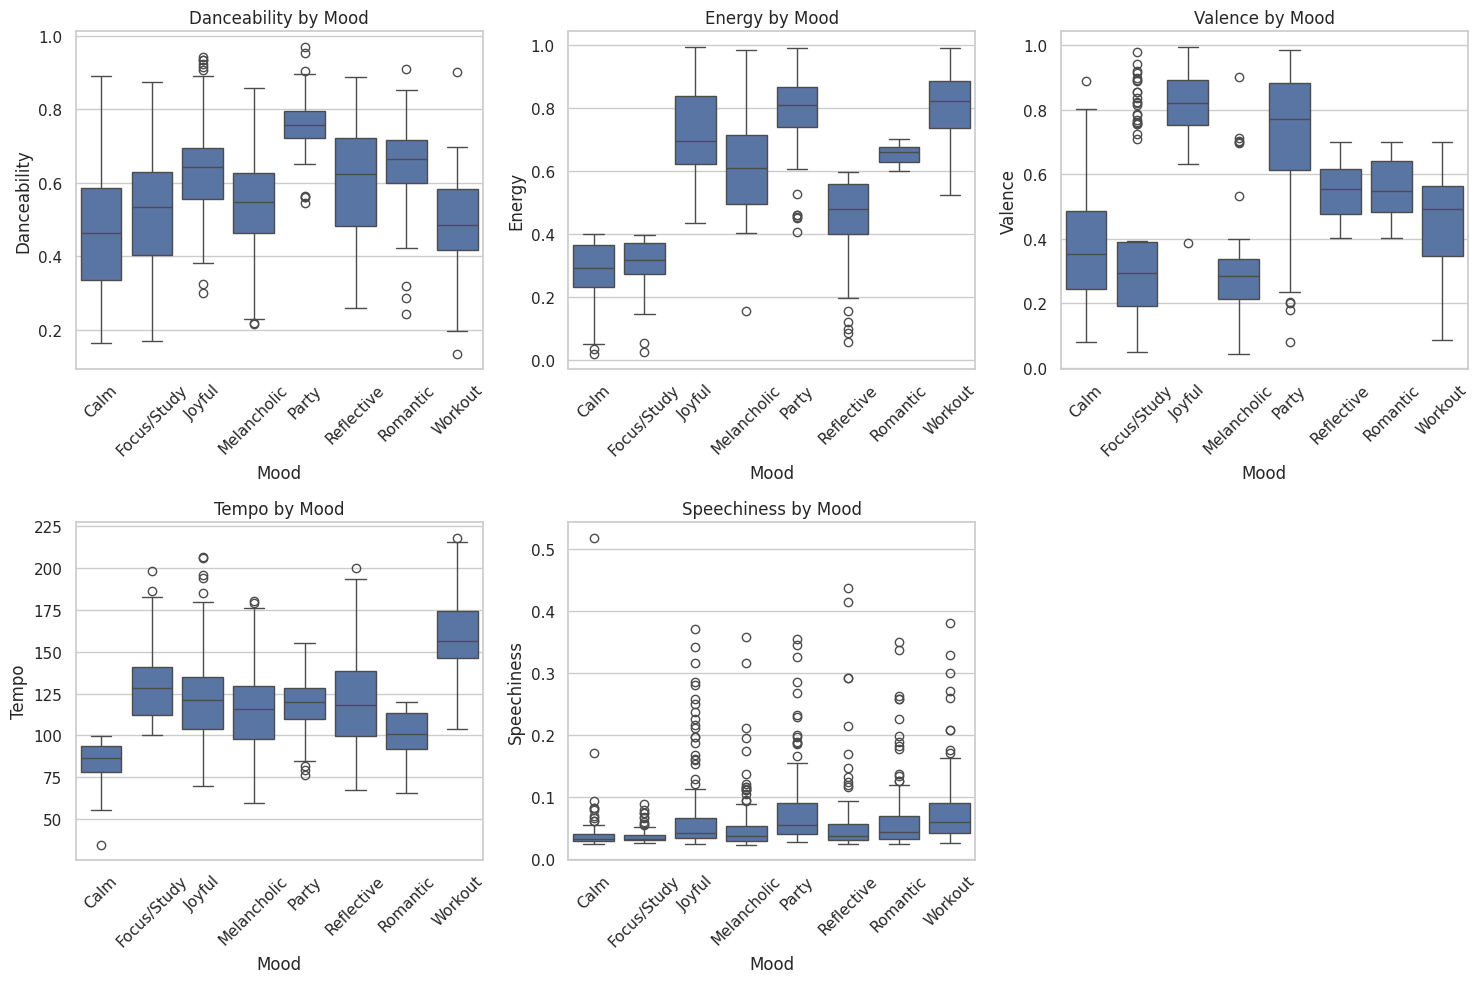

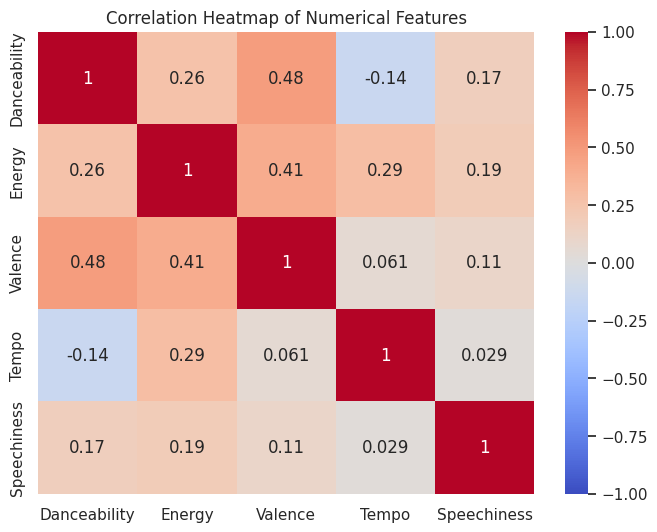

In [6]:

# Load the cleaned dataset
df = pd.read_csv('animosic_dataset_cleaned.csv')

# Set plotting style
sns.set(style="whitegrid")

# Mood Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Mood', data=df, order=df['Mood'].value_counts().index)
plt.title('Distribution of Moods')
plt.xticks(rotation=45)
plt.show()

# Distribution of Numerical Features
numerical_cols = ['Danceability', 'Energy', 'Valence', 'Tempo', 'Speechiness']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Feature Relationships with Mood (Boxplots)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Mood', y=col, data=df)
    plt.title(f'{col} by Mood')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation Heatmap of Numerical Features
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Cross-validation Accuracy scores: [0.9625  0.9625  0.95625 0.96875 0.98125]
Mean CV Accuracy: 0.9662499999999999

Cross-validation F1-macro scores: [0.96501783 0.96210285 0.95940842 0.97419144 0.98187486]
Mean CV F1-macro: 0.9685190814930801

Test Accuracy: 0.935

Classification Report:
               precision    recall  f1-score   support

        Calm       1.00      1.00      1.00        20
 Focus/Study       0.87      1.00      0.93        20
      Joyful       0.95      0.97      0.96        40
 Melancholic       0.82      0.93      0.88        30
       Party       0.96      0.83      0.89        30
  Reflective       1.00      0.90      0.95        20
    Romantic       0.95      1.00      0.98        20
     Workout       1.00      0.85      0.92        20

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.93       200



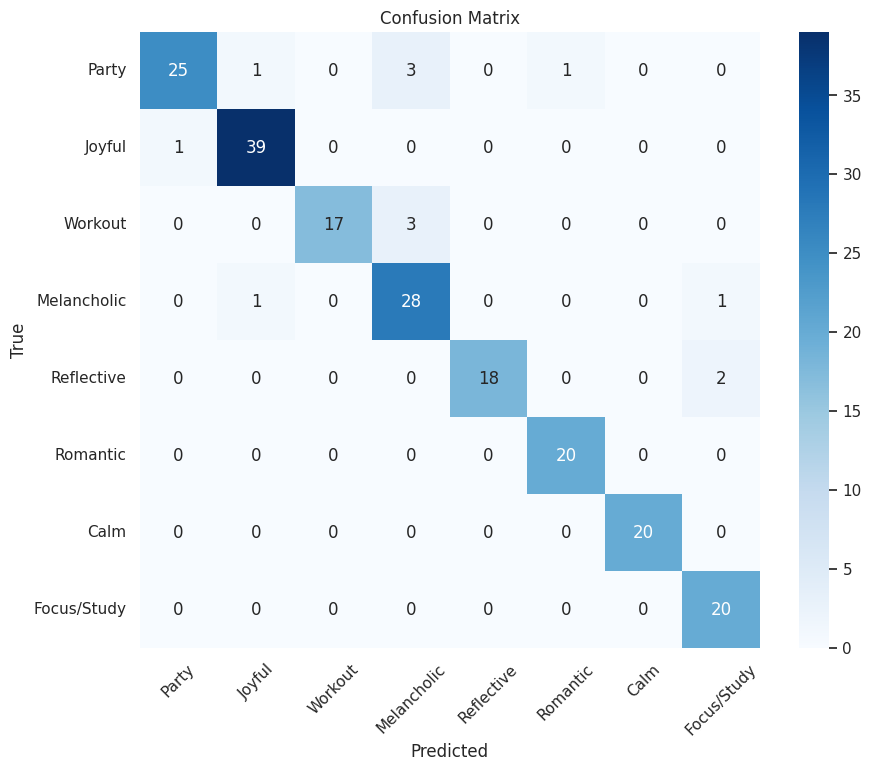


Model and scaler saved as 'animosic_mood_model.pkl' and 'animosic_scaler.pkl'


In [10]:

# train the model


X = df[['Danceability', 'Energy', 'Valence', 'Tempo', 'Speechiness']]
y = df['Mood']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights
classes = y_train.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train_scaled, y_train)

# Cross-validation
cv_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_f1_macro = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print("Cross-validation Accuracy scores:", cv_accuracy)
print("Mean CV Accuracy:", cv_accuracy.mean())
print("\nCross-validation F1-macro scores:", cv_f1_macro)
print("Mean CV F1-macro:", cv_f1_macro.mean())

# Evaluate on test set
y_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
# Save the model and scaler
joblib.dump(model, 'animosic_mood_model1.pkl')
joblib.dump(scaler, 'animosic_scaler1.pkl')
print("\nModel and scaler saved as 'animosic_mood_model.pkl' and 'animosic_scaler.pkl'")

In [12]:
## MAKE PREDICTION FOR THE DATABASE TRACKS


# Load the main database and cleaned dataset
df_main = pd.read_csv('top_10000_1960-now.csv')
df_cleaned = pd.read_csv('animosic_dataset_cleaned.csv')

# Exclude songs already in the cleaned dataset and create a copy
df_main_unpredicted = df_main[~df_main['Track URI'].isin(df_cleaned['Track URI'])].copy()

# Features for prediction
X_main = df_main_unpredicted[['Danceability', 'Energy', 'Valence', 'Tempo', 'Speechiness']]

# Load the saved model and scaler
model = joblib.load('animosic_mood_model1.pkl')
scaler = joblib.load('animosic_scaler1.pkl')

# Scale features
X_main_scaled = scaler.transform(X_main)

# Predict moods
df_main_unpredicted.loc[:, 'Mood'] = model.predict(X_main_scaled)

# Keep only relevant columns
df_main_unpredicted = df_main_unpredicted[['Track URI', 'Track Name', 'Artist Name(s)', 'Artist Genres', 'Danceability', 'Energy', 'Valence', 'Tempo', 'Speechiness', 'Mood']]

# Save the predicted dataset
df_main_unpredicted.to_csv('main_database_predicted.csv', index=False)

# Print summary
print("Number of songs predicted:", len(df_main_unpredicted))
print("\nMood distribution in predicted dataset:\n", df_main_unpredicted['Mood'].value_counts())
print("\nSample of predicted dataset:\n", df_main_unpredicted.head())

Number of songs predicted: 8991

Mood distribution in predicted dataset:
 Mood
Joyful         2372
Party          1945
Melancholic    1495
Romantic       1015
Reflective      832
Workout         788
Focus/Study     277
Calm            267
Name: count, dtype: int64

Sample of predicted dataset:
                               Track URI  \
0  spotify:track:1XAZlnVtthcDZt2NI1Dtxo   
1  spotify:track:6a8GbQIlV8HBUW3c6Uk9PH   
2  spotify:track:70XtWbcVZcpaOddJftMcVi   
5  spotify:track:4bEb3KE4mSKlTFjtWJQBqO   
6  spotify:track:0d2iYfpKoM0QCKvcLCkBao   

                                Track Name                Artist Name(s)  \
0  Justified & Ancient - Stand by the Jams                       The KLF   
1          I Know You Want Me (Calle Ocho)                       Pitbull   
2       From the Bottom of My Broken Heart                Britney Spears   
5               Don't Stop - 2004 Remaster                 Fleetwood Mac   
6          Eastside (with Halsey & Khalid)  benny blanco, Halsey,